# Aprendizaje Automático para Datos en Grafos - Laboratorio 1
## Introducción al procesamiento de grafos, NetworkX y PyTorch Geometric

En este laboratorio tomaremos un dataset real, generaremos grafos a partir de él y lo analizaremos mediante la biblioteca **[NetworkX](https://networkx.org/)**. En el camino, aprovechamos para presentar la biblioteca **pandas**, excelente para levantar datos y poder procesarlos de manera rápida y cómoda. También empezaremos a familarizarnos con **PyTorch Geometric**, una biblioteca que nos será útil para trabajar con redes neuronales en grafos (GNNs).

Como excusa para esto, usaremos el dataset de Enron. Los detalles del escándalo se pueden consultar en https://en.wikipedia.org/wiki/Enron_scandal. Durante la investigación se publicaron los mails que recibieron y enviaron varios empleados de Enron entre noviembre de 1998 y junio de 2002. El dataset completo se puede consultar en http://www.cs.cmu.edu/~enron/. Aquí usaremos una versión curada y resumida (por ejemplo, no contiene el cuerpo de los mensajes) que se puede consultar en http://cis.jhu.edu/~parky/Enron/enron.html.

El objetivo es que aquellos que nunca tuvieron contacto con alguna de estas bibliotecas aprendan mínimamente a usarlas. Para el curso, se pide que entreguen las respuestas a las preguntas planteadas, pero cualquier exploración por fuera del camino trazado es más que bienvenida.

## Generando el grafo

In [1]:
# importemos bibliotecas que vamos a usar
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# bajemos el dataset (ver http://cis.jhu.edu/~parky/Enron/enron.html por los detalles)
!wget http://cis.jhu.edu/~parky/Enron/employees
!wget http://cis.jhu.edu/~parky/Enron/execs.email.linesnum

--2025-08-23 11:39:21--  http://cis.jhu.edu/~parky/Enron/employees
Resolving cis.jhu.edu (cis.jhu.edu)... 128.220.194.98
Connecting to cis.jhu.edu (cis.jhu.edu)|128.220.194.98|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://www.cis.jhu.edu/~parky/Enron/employees [following]
--2025-08-23 11:39:22--  https://www.cis.jhu.edu/~parky/Enron/employees
Resolving www.cis.jhu.edu (www.cis.jhu.edu)... 104.18.36.137, 172.64.151.119, 2606:4700:4400::ac40:9777, ...
Connecting to www.cis.jhu.edu (www.cis.jhu.edu)|104.18.36.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8805 (8.6K)
Saving to: ‘employees.2’

employees.2         100%[===================>]   8.60K  --.-KB/s    in 0s      

2025-08-23 11:39:24 (1.37 GB/s) - ‘employees.2’ saved [8805/8805]

--2025-08-23 11:39:24--  http://cis.jhu.edu/~parky/Enron/execs.email.linesnum
Resolving cis.jhu.edu (cis.jhu.edu)... 128.220.194.98
Connecting to cis.jhu.edu (cis.jhu.edu)|

In [3]:
# carguemos los datos
df_mails = pd.read_csv('execs.email.linesnum', names=['time','from','to'], sep=' ')
df_employees = pd.read_csv('employees', sep='\t', names=['mail', 'name and more'])

En la variable `df_mails` tenemos un [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) de pandas con el id de quien (columna `from`) le envió un mail a quien (`to`) y cuándo (`time`). A su vez, el usuario de mail y otros datos de cada usuario está en el dataframe `df_employees`. Un dataframe se puede pensar como una tabla indexada, pero además pandas da muchas facilidades, algunas de las cuales vamos a aprovechar para procesar los datos y generar el grafo.

In [4]:
# calculamos las fechas a partir del timestamp (de segundos desde el 1/1/1970 a una fecha)
df_mails['date'] = pd.to_datetime(df_mails.time, unit='s')

# no sé porque hay fechas del 79. Olimpicamente las borramos.
df_mails = df_mails[df_mails.date.dt.year>1980]

df_mails.head()

,time,from,to,date
174,910948020,114,169,1998-11-13 09:07:00
175,910948020,114,169,1998-11-13 09:07:00
176,911477940,114,123,1998-11-19 12:19:00
177,911477940,114,123,1998-11-19 12:19:00
178,911481840,114,123,1998-11-19 13:24:00


### Generación del grafo de todo el período

Primero vamos a crear un grafo que abarque todos los mails.


In [73]:
# cuento cuántos mails hubo entre dos usuarios
mails_intercambiados = df_mails.groupby(['from', 'to']).count().reset_index()
mails_intercambiados.head()


,from,to,time,date,week
0,0,9,23,23,23
1,0,20,4,4,4
2,0,48,2,2,2
3,0,91,2,2,2
4,0,104,1,1,1


In [74]:
# las columnas "time" y "date" tienen todo lo mismo, asi que arbitrariamente cambio una a "weight" para usarlo como peso en el grafo
mails_intercambiados.rename(columns={'time':'weight'}, inplace=True)
mails_intercambiados.head()

,from,to,weight,date,week
0,0,9,23,23,23
1,0,20,4,4,4
2,0,48,2,2,2
3,0,91,2,2,2
4,0,104,1,1,1


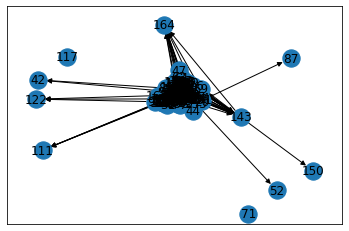

In [76]:
# Y acá viene lo interesante: pandas se integra con networkx.
G = nx.from_pandas_edgelist(mails_intercambiados, source='from', target='to', edge_attr='weight', create_using=nx.DiGraph)

# Saco self loops
G.remove_edges_from(nx.selfloop_edges(G))

G_full = G

# dibujamos el grafo sin hacer mucho esfuerzo ...
nx.draw_networkx(G)
plt.show()

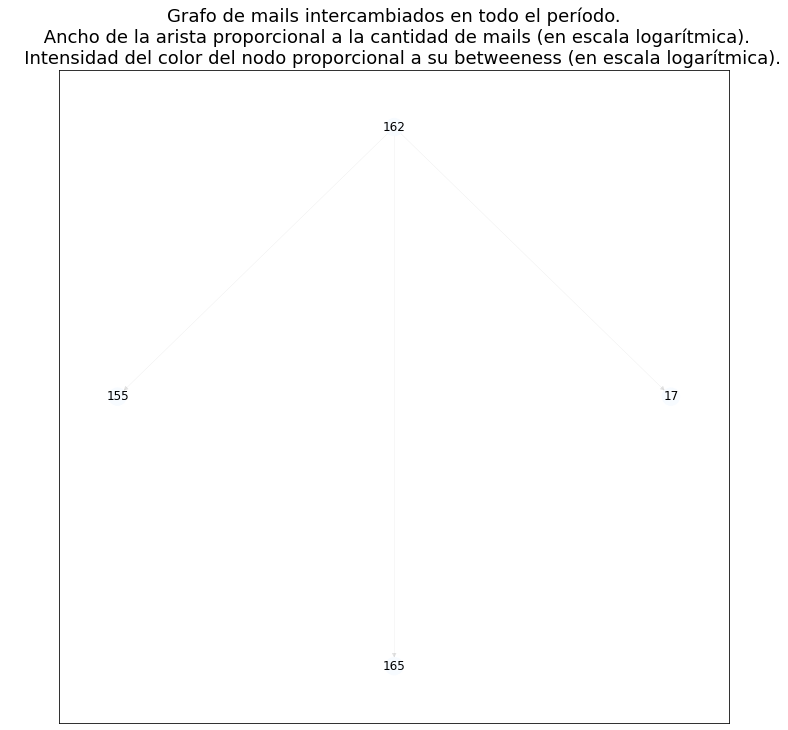

In [72]:
# ... pero no se aprecia mucho, porque los nodos quedan muy apretados.

# Así que ahora nos vamos a poner un poco más las pilas
posiciones = nx.circular_layout(G)
edges = G.edges()
weights = np.array([G[u][v]['weight'] for u,v in edges])

between_dict = nx.betweenness_centrality(G)
between = np.array(list(between_dict.values()))

plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G, pos=posiciones, node_color=10*np.log(1+between/(np.min(between)+1e-9)), cmap='Blues')
nx.draw_networkx_edges(G, alpha=0.1, width=np.log10(weights+1), pos=posiciones)
nx.draw_networkx_labels(G, pos=posiciones, font_color='black')
plt.title('Grafo de mails intercambiados en todo el período.\n Ancho de la arista proporcional a la cantidad de mails (en escala logarítmica).\n \
  Intensidad del color del nodo proporcional a su betweeness (en escala logarítmica).', fontsize=18)
plt.show()

### Interfaz de NetworkX con NumPy

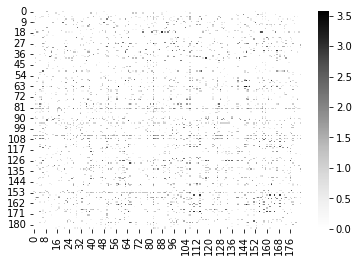

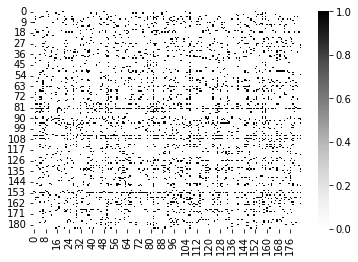

In [9]:
# Además de tener interfaz hacia pandas, NetworkX puede trabajar con NumPy y matrices

# por ejemplo, la matriz de adyacencia se obtiene así de sencillo
G_np = nx.to_numpy_array(G,nodelist=range(G.number_of_nodes()))
# y la ploteo usando seaborn
sns.heatmap(np.log10(G_np+1), cmap='Greys')
plt.show()
# o si quisiera mirar solo la conectividad...
sns.heatmap(G_np>0, cmap='Greys')
plt.show()


## Análisis del grafo completo

Ahora deberá usar la API de Networkx o NumPy para calcular distintos indicadores del grafo `G`:


1.   Número de aristas dirigidas (arcos).
2.   Número de aristas no-dirigidas (es decir, si existe al menos una de las dos direcciones entre un par de nodos (i,j), entonces se cuenta como 1).
3.   Número de arcos mutuos (es decir, pares de nodos con "ida y vuelta").
4.   Número de nodos con in-degree igual a 0 (o sea, empleados que no recibieron mails). ¿A qué personas corresponde?
5.   Número de nodos con out-degree igual a 0 (o sea, empleados que no enviaron mails). ¿A qué personas corresponde?
6.   El número de empleados que fueron contactados por más de 30 empleados. Re-haga el dibujo del grafo marcando estos nodos en rojo y haciendo aparecer su nombre.
7.   El número de empleados que contactaron a más de 30 empleados. Re-haga el dibujo del grafo marcando estos nodos en rojo y haciendo aparecer su nombre.
8.   El histograma del grado de los nodos (in y out). Se puede utilizar por ejemplo la herramienta histplot de seaborn.



#### Número de aristas dirigidas

In [10]:
n_edges = nx.number_of_edges(G)
print("Number of edges:", n_edges)

Number of edges: 3007


#### Número de aristas no-dirigidas

In [11]:
n_undirected = G.to_undirected().number_of_edges()
print("Number of undirected edges:", n_undirected)

Number of undirected edges: 2097


#### Número de arcos mutuos

In [12]:
n_arcos_mutuos = G.to_undirected(reciprocal=True).number_of_edges()
print("Number of arcos mutuos:", n_arcos_mutuos)

Number of arcos mutuos: 910


In [13]:
n_arcos_mutuos = n_edges - n_undirected

#### Nodos con in-degree 0

In [14]:
nodes = list(nx.nodes(G).keys())
adj = nx.adjacency_matrix(G)
in_degree = adj.sum(axis=1)
idx_degree_zero, _ = np.where(in_degree==0)
print("Cantidad de nodos con in-degree==0:", len(idx_degree_zero))
print("nodos:", ", ".join([str(nodes[i]) for i in idx_degree_zero]))

Cantidad de nodos con in-degree==0: 9
nodos: 164, 122, 111, 42, 71, 87, 117, 150, 52


/var/folders/p6/bczkg05n3kjbf6fdy02s4zd40000gn/T/ipykernel_35754/4101065831.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G)


In [15]:
adj = nx.adjacency_matrix(G)
out_degree = adj.sum(axis=0).T
idx_odegree_zero, _ = np.where(out_degree==0)
print("Cantidad de nodos con in-degree==0:", len(idx_odegree_zero))
print("nodos:", ", ".join([str(nodes[i]) for i in idx_odegree_zero]))

Cantidad de nodos con in-degree==0: 3
nodos: 71, 117, 135


/var/folders/p6/bczkg05n3kjbf6fdy02s4zd40000gn/T/ipykernel_35754/3859923602.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G)


#### 6: empleados con más de 30 contactos

In [16]:
nodes = list(nx.nodes(G).keys())
adj = nx.adjacency_matrix(G) > 1
in_degree = adj.sum(axis=1)
popular_employees_idx, _ = np.where(in_degree > 30)

popular_employees = np.array([nodes[idx] for idx in popular_employees_idx])
df_popular_employees = df_employees.iloc[popular_employees]
print(len(popular_employees))
df_popular_employees

18


/var/folders/p6/bczkg05n3kjbf6fdy02s4zd40000gn/T/ipykernel_35754/2093666567.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G) > 1


,mail,name and more
82,john.lavorato,John Lavorato CEO Enro...
107,louise.kitchen,Louise Kitchen President Enron O...
157,scott.neal,Scott Neal Vice President
140,phillip.allen,Philip Allen Manager
78,john.arnold,John Arnold Vice President
105,liz.taylor,xxx
153,sally.beck,Sally Beck Employee Chief O...
169,tana.jones,Tana Jones N/A
94,kenneth.lay,Kenneth Lay CEO
27,david.delainey,David Delainey CEO Enro...


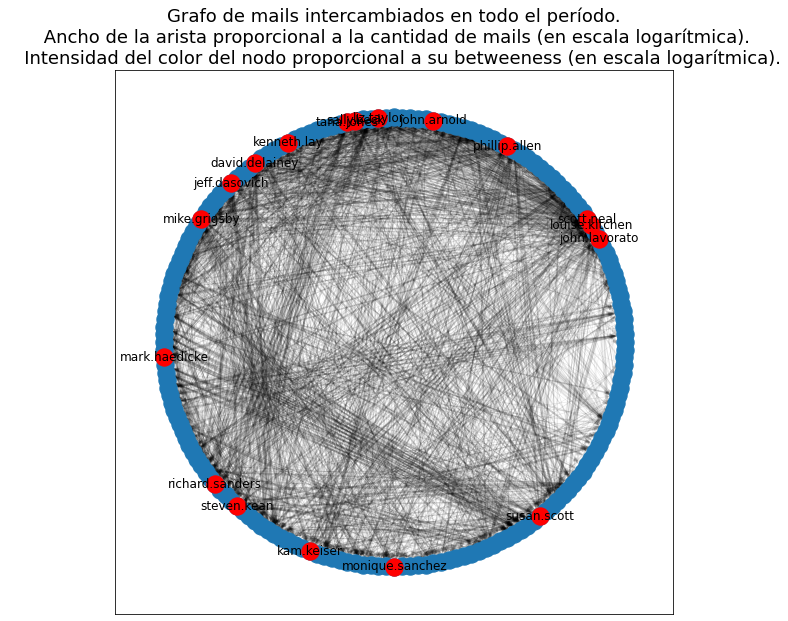

In [17]:
posiciones = nx.circular_layout(G)
edges = G.edges()
weights = np.array([G[u][v]['weight'] for u,v in edges])

popular_subgraph = G.subgraph(popular_employees)

plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos=posiciones)
nx.draw_networkx_nodes(popular_subgraph, pos=posiciones, node_color="red")
nx.draw_networkx_edges(G, alpha=0.1, width=np.log10(weights+1), pos=posiciones)
# nx.draw_networkx_labels(G, pos=posiciones, font_color='black')
nx.draw_networkx_labels(popular_subgraph, pos=posiciones, labels=df_popular_employees['mail'])
plt.title('Grafo de mails intercambiados en todo el período.\n Ancho de la arista proporcional a la cantidad de mails (en escala logarítmica).\n \
  Intensidad del color del nodo proporcional a su betweeness (en escala logarítmica).', fontsize=18)
plt.show()

#### 7: empleados que contactaron más de 30

In [18]:
nodes = list(nx.nodes(G).keys())
adj = nx.adjacency_matrix(G) > 1
out_degree = adj.sum(axis=0).T
popular_employees_idx, _ = np.where(out_degree > 30)

popular_employees = np.array([nodes[idx] for idx in popular_employees_idx])
print(len(popular_employees))
df_popular_employees = df_employees.iloc[popular_employees]
print(df_popular_employees)
df_popular_employees

8
               mail                                      name and more
82    john.lavorato  John Lavorato          CEO                Enro...
107  louise.kitchen  Louise Kitchen      President          Enron O...
157      scott.neal             Scott Neal              Vice President
140   phillip.allen                        Philip Allen        Manager
51     greg.whalley                   Greg Whalley           President
78      john.arnold             John Arnold             Vice President
27   david.delainey  David Delainey         CEO                Enro...
126    mike.grigsby                    Michael Grigsby         Manager


/var/folders/p6/bczkg05n3kjbf6fdy02s4zd40000gn/T/ipykernel_35754/3960394203.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G) > 1


,mail,name and more
82,john.lavorato,John Lavorato CEO Enro...
107,louise.kitchen,Louise Kitchen President Enron O...
157,scott.neal,Scott Neal Vice President
140,phillip.allen,Philip Allen Manager
51,greg.whalley,Greg Whalley President
78,john.arnold,John Arnold Vice President
27,david.delainey,David Delainey CEO Enro...
126,mike.grigsby,Michael Grigsby Manager


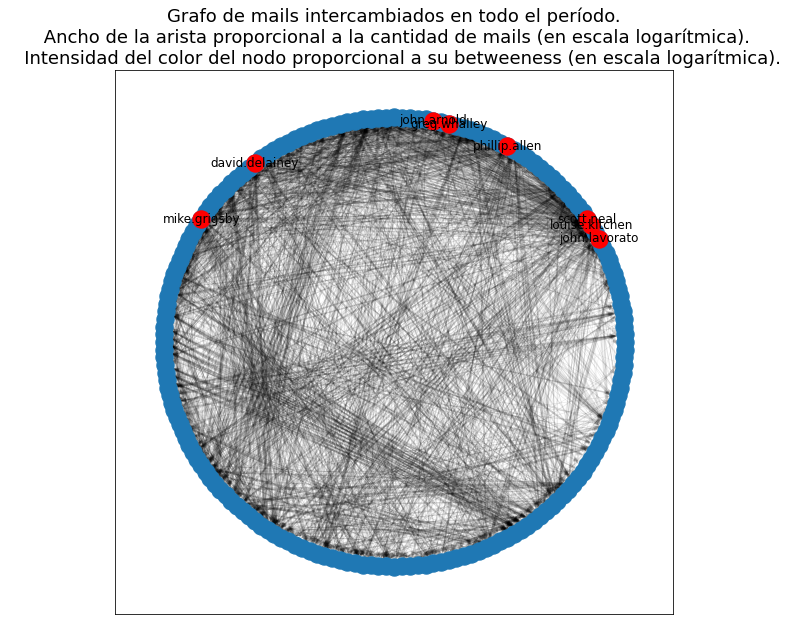

In [19]:
posiciones = nx.circular_layout(G)
edges = G.edges()
weights = np.array([G[u][v]['weight'] for u,v in edges])

popular_subgraph = G.subgraph(popular_employees)

plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos=posiciones)
nx.draw_networkx_nodes(popular_subgraph, pos=posiciones, node_color="red")
nx.draw_networkx_edges(G, alpha=0.1, width=np.log10(weights+1), pos=posiciones)
# nx.draw_networkx_labels(G, pos=posiciones, font_color='black')
nx.draw_networkx_labels(popular_subgraph, pos=posiciones, labels=df_popular_employees['mail'])
plt.title('Grafo de mails intercambiados en todo el período.\n Ancho de la arista proporcional a la cantidad de mails (en escala logarítmica).\n \
  Intensidad del color del nodo proporcional a su betweeness (en escala logarítmica).', fontsize=18)
plt.show()

#### 8. Histograma del grado de los nodos

#### 

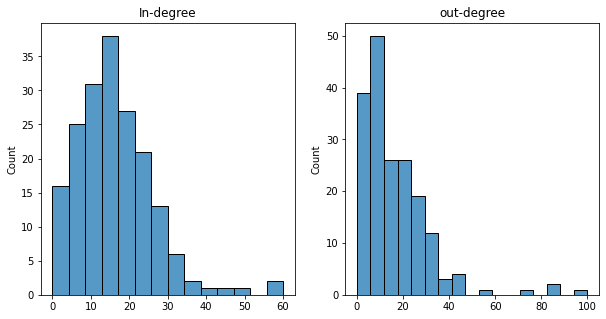

In [20]:
_, in_degrees = list(zip(*list(G.in_degree)))
_, out_degrees = list(zip(*list(G.out_degree)))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("In-degree")
sns.histplot(in_degrees)
plt.subplot(1,2,2)
plt.title("out-degree")
sns.histplot(out_degrees)
plt.show()

## Análisis temporal del grafo

Hasta ahora miramos la totalidad de los datos e ignoramos la componente temporal del mismo. Ahora vamos a analizar mínimamente cómo cambia el grafo con el tiempo.

In [21]:
# los voy a agrupar por semana, asi que primero me fijo a que semana corresponde cada mail y lo agrego a df_mails
df_mails['week'] = df_mails.date.dt.to_period('W')
print(df_mails.head())

# Agrupo por semana. Esto genera un objeto GroupBy sobre el que puedo iterar, y contiene
# los datos correspondientes a cada semana
grouped_week = df_mails.groupby('week')
# lista que contendrá los grafos correspondientes a cada semana
grafos = []
# lista que contendrá las semanas propiamente dichas. Se puede usar para identificar tiempo más adelante.
semanas = []

for semana, grupo_mails in grouped_week:
    # básicamente repito lo que hice antes para el grafo grande, pero ahora por semana.
    # Voy a ir guardando los grafos en una lista. Quizá no sea lo más eficiente, pero el
    # dataset no es muy grande.

    # cuento cuantos mails hubo en esta semana entre dos usuarios
    mails_intercambiados = grupo_mails.groupby(['from', 'to']).count().reset_index()
    # las columnas tienen todo lo mismo, asi que arbitrariamente cambio una a "weight" para usarlo como peso en el grafo
    mails_intercambiados.rename(columns={'week':'weight'}, inplace=True)
    G = nx.from_pandas_edgelist(mails_intercambiados, source='from', target='to', edge_attr='weight', create_using=nx.DiGraph)

    # Saco self loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # agrego el nuevo grafo a la lista
    grafos.append(G)
    semanas.append(semana)



          time  from   to                date                   week
174  910948020   114  169 1998-11-13 09:07:00  1998-11-09/1998-11-15
175  910948020   114  169 1998-11-13 09:07:00  1998-11-09/1998-11-15
176  911477940   114  123 1998-11-19 12:19:00  1998-11-16/1998-11-22
177  911477940   114  123 1998-11-19 12:19:00  1998-11-16/1998-11-22
178  911481840   114  123 1998-11-19 13:24:00  1998-11-16/1998-11-22


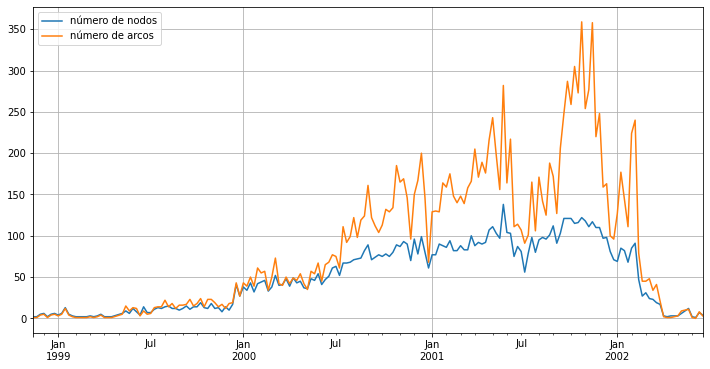

In [22]:
# vamos a mirar algunos indicadores

numero_de_nodos = [grafo.number_of_nodes() for grafo in grafos]
numero_de_arcos = [grafo.number_of_edges() for grafo in grafos]
pd.DataFrame({'n_nodos':numero_de_nodos, 'n_arcos':numero_de_arcos}, index=semanas).plot(figsize=(12,6))
plt.grid()
plt.legend(['número de nodos', 'número de arcos'])
plt.show()


### Cambios en el grafo:
9. Elija dos indicadores de nodo e indique cuál fue la persona más importante para cada instante de tiempo según cada indicador. Justifique su elección del indicador.  Compárelo con el grafo "completo" (i.e. considerando todo el tiempo).
10. Considere algunos indicadores a nivel de grafo y trate de identificar algún evento en el escándalo (la figura 8 de https://arxiv.org/abs/1403.0989 tiene un timeline muy prolijo que puede ayudar). Con toda seguridad el lanzamiento de Enron online y la asunción de Stephen Cooper como CEO son fácilmente detectables.

#### 9. Persona importante

Betweeness centrality: mide la importancia de un nodo para el flujo de la información.

In [ ]:
def get_max(centralities: dict[int, float]) -> tuple[int, float]:
    most_popular = 0
    top_value = -1
    for k, c in centralities.items():
        if c > top_value:
            most_popular = k
            top_value = c
    return {"nodo": most_popular, "centrality": top_value}


betweeness_centrality = [nx.betweenness_centrality(G) for G in grafos]
top_centralities = pd.DataFrame([get_max(cent) for cent in betweeness_centrality], index=semanas)

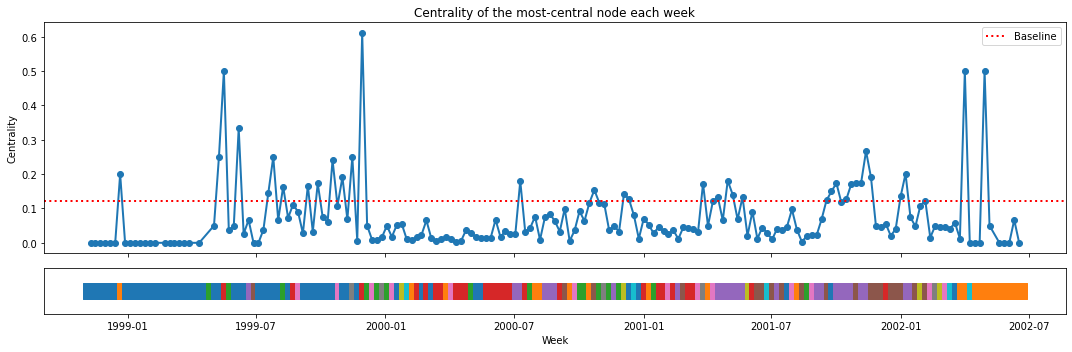

Esta el nodo central al grafo semana a semana? True
Nodo central: 82


114    45
169    20
82     15
107    11
17      9
112     7
27      7
126     6
155     6
38      6
63      5
50      3
6       3
58      3
153     3
110     2
145     2
105     2
98      2
163     2
165     2
118     2
9       2
37      1
123     1
146     1
140     1
178     1
132     1
65      1
99      1
67      1
34      1
4       1
8       1
133     1
158     1
103     1
177     1
124     1
73      1
66      1
Name: nodo, dtype: int64

In [86]:
def plot_max_values_with_nodes(top, title='Centrality of the most-central node each week', baseline=None):
    #  Build a colour palette for the nodes that are maximun at any point
    unique_nodes = top['nodo'].unique()
    palette      = sns.color_palette('tab10', len(unique_nodes))
    node2colour  = dict(zip(unique_nodes, palette))

    _, (ax1, ax2) = plt.subplots(
        nrows=2, sharex=True,
        figsize=(15, 5),
        gridspec_kw={'height_ratios': [5, 1]}
    )

    ax1.plot(top.index.to_timestamp(), top['centrality'],
            marker='o', linewidth=2)
    ax1.set_ylabel('Centrality')
    ax1.set_title(title)

    # Add baseline if provided
    if baseline is not None:
        ax1.axhline(y=baseline, color='red', linestyle=':', linewidth=2, label='Baseline')
        # Optionally add legend for baseline
        ax1.legend()

    # 4-b. coloured squares for the node that won (bottom)
    ax2.scatter(top.index.to_timestamp(), [0]*len(top),
                c=top['nodo'].map(node2colour),
                marker='s', s=250)          # square marker
    ax2.set_yticks([])                      # hide y-axis
    ax2.set_xlabel('Week')

    # handles = [mpatches.Patch(color=node2colour[n], label=n)
            # for n in unique_nodes]
    plt.tight_layout()

full_graph_centrality = get_max(nx.betweenness_centrality(G_full))
plot_max_values_with_nodes(top_centralities, baseline=full_graph_centrality['centrality'])
plt.show()

print('Esta el nodo central al grafo semana a semana?', full_graph_centrality['nodo'] in top_centralities['nodo'].to_list())
print("Nodo central:", full_graph_centrality['nodo'])
top_centralities['nodo'].value_counts().sort_values(ascending=False)

# los colores estan acorde a los colores de top['nodo'].unique()

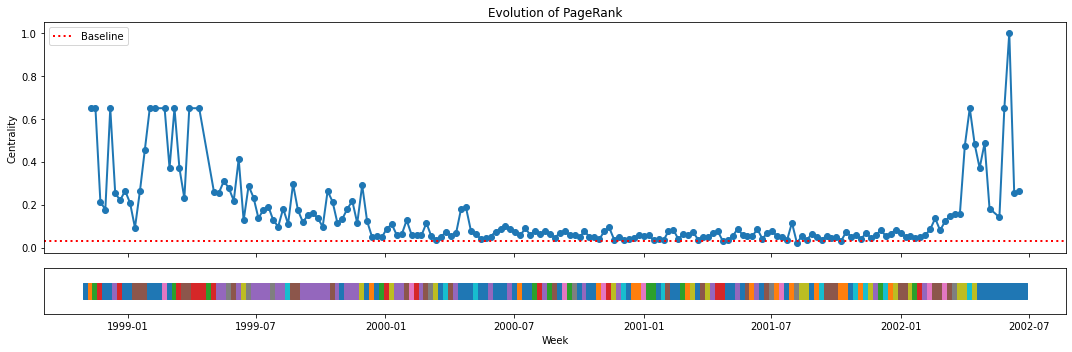

Esta el nodo central al grafo semana a semana? True
Nodo central: 82


114    29
169    25
155    14
50     10
107     9
98      7
17      7
82      6
65      6
124     5
66      4
151     4
38      4
110     3
92      3
22      3
58      3
165     2
51      2
112     2
103     2
9       2
78      2
163     2
27      2
130     1
11      1
145     1
123     1
171     1
115     1
157     1
39      1
178     1
99      1
132     1
167     1
24      1
13      1
109     1
49      1
162     1
183     1
41      1
158     1
161     1
170     1
36      1
104     1
6       1
146     1
Name: nodo, dtype: int64

In [89]:
page_rank = [nx.pagerank(G) for G in grafos]
top_pagerank = pd.DataFrame([get_max(rank) for rank in page_rank], index=semanas)

full_graph_pagerank = get_max(nx.pagerank(G_full))
plot_max_values_with_nodes(top_pagerank, title="Evolution of PageRank", baseline=full_graph_pagerank['centrality'])
plt.show()
print('Esta el nodo central al grafo semana a semana?', full_graph_pagerank['nodo'] in top_pagerank['nodo'].to_list())
print("Nodo central:", full_graph_pagerank['nodo'])
top_pagerank['nodo'].value_counts().sort_values(ascending=False)




### 10. Indicadores de grafo

In [110]:
n_nodes = [G.number_of_nodes() for G in grafos]
n_edges = [G.number_of_edges() for G in grafos]
max_degree = [max(dict(G.degree()).values()) for G in grafos]
mean_degree = [np.mean(list(dict(G.degree()).values())) for G in grafos]
clustering_coefficient = [nx.average_clustering(G) for G in grafos]

df_grafo = pd.DataFrame({
    "n_nodes": n_nodes,
    "n_edges": n_edges,
    "max_degree": max_degree,
    "mean_degree": mean_degree,
    "clustering_coefficient": clustering_coefficient
}, index=semanas)

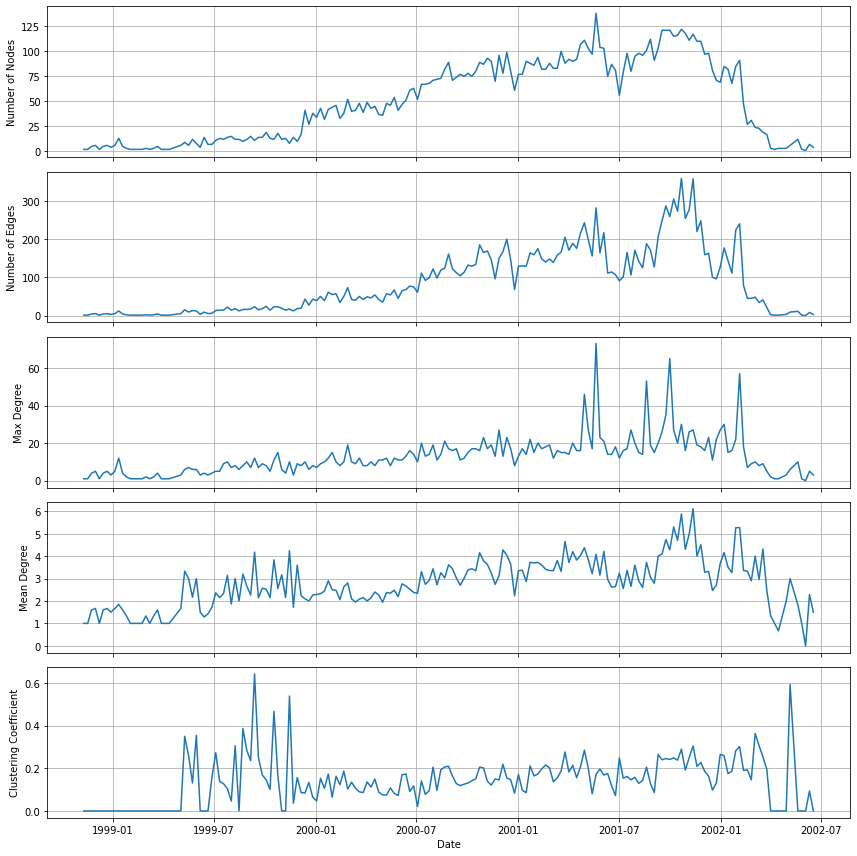

In [125]:
fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

metrics = [
    ("n_nodes", "Number of Nodes"),
    ("n_edges", "Number of Edges"),
    ("max_degree", "Max Degree"),
    ("mean_degree", "Mean Degree"),
    ("clustering_coefficient", "Clustering Coefficient")
]

for i, (col, ylabel) in enumerate(metrics):
    ax = axes[i]
    # Use bar plot, with bars covering the period
    sns.lineplot(x=df_grafo.index.to_timestamp(),y=df_grafo[col], ax=ax )
    ax.set_ylabel(ylabel)
    ax.set_xlabel('')  # Remove x label for all but last
    ax.grid()

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

## Una introducción a Pytorch Geometric (PyG)
**[PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric)** es una bilbioteca de Python para trabajar con aprendizaje profundo en grafos, a través de las redes neuronales de grafos (Graph Neural Networks o GNNs). La biblioteca es una extensión de **[PyTorch](https://pytorch.org/)**, un framework de deep learning muy utilizado.

In [128]:
# Instalo PyG
!uv pip install torch-geometric

Resolved 23 packages in 421ms                                        
⠙ Preparing packages... (0/7)                                                   
⠙ Preparing packages... (0/7)--------------     0 B/202.83 KiB          
⠙ Preparing packages... (0/7)--------------     0 B/202.83 KiB          
async-timeout        ------------------------------     0 B/6.09 KiB
⠙ Preparing packages... (0/7)--------------     0 B/202.83 KiB          
async-timeout        ------------------------------     0 B/6.09 KiB
⠙ Preparing packages... (0/7)-------------- 16.00 KiB/202.83 KiB        
async-timeout        ------------------------------ 6.09 KiB/6.09 KiB
⠙ Preparing packages... (0/7)-------------- 16.00 KiB/202.83 KiB        
async-timeout        ------------------------------ 6.09 KiB/6.09 KiB
⠙ Preparing packages... (0/7)-------------- 16.00 KiB/202.83 KiB        
async-timeout        ------------------------------ 6.09 KiB/6.09 KiB
⠙ Preparing packages... (0/7)-------------- 32.00 KiB/202.83 Ki

PyG tiene varios datasets de grafos en el paquete **[torch_geometric.datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets)**. En esta parte trabajaremos con un dataset bastante utilizado para hacer pruebas de concepto en el área: el [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [129]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Cantidad de grafos: {len(dataset)}')
print(f'Cantidad de features: {dataset.num_features}')
print(f'Cantidad de clases: {dataset.num_classes}')

Dataset: KarateClub():
Cantidad de grafos: 1
Cantidad de features: 34
Cantidad de clases: 4


El dataset está formado por un único grafo, cada nodo del grafo tiene asociado un vector en $\mathbb{R}^{34}$ (llamado vector de *features*), y hay 4 clases de nodos. Veamos en más detalle algunas estadísticas del grafo:

In [130]:
# Miro el primer grafo
data = dataset[0]

print(data)
print('==============================================================')

# Estadísticas del grafo.
print(f'Cantidad de nodos: {data.num_nodes}')
print(f'Cantidad de aristas: {data.num_edges}')
print(f'Grado promedio de nodo: {(2*data.num_edges) / data.num_nodes:.2f}')
print(f'Tiene nodos aislados: {data.has_isolated_nodes()}')
print(f'Tiene self-loops: {data.has_self_loops()}')
print(f'Es no dirigido: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Cantidad de nodos: 34
Cantidad de aristas: 156
Grado promedio de nodo: 9.18
Tiene nodos aislados: False
Tiene self-loops: False
Es no dirigido: True


Un grafo en PyG está representado por un objeto de tipo [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data). Cada uno de estos objetos tiene al menos 5 atributos:
- **`x`**: es la matriz de features del grafo (es decir, la matriz cuyas columnas son los featues de cada nodo del grafo). Es un objeto de tipo [`tensor`](https://pytorch.org/docs/stable/tensors.html), el tipo nativo de torch para guardar matrices (el equivalente a [`ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) en numpy).
- **`edge_index`**: es la matriz de conectividad del grafo, en formato [COO](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)). Este formato es muy útil para guardar matrices *ralas* o *esparsas* (matrices con muchos ceros en sus entradas). Consiste en guardar solamente la lista de nodos que están conectados, en lugar de guardar toda la matriz de adyacencia del grafo.
- **`y`**: es la matriz de etiquetas de cada nodo (en este ejemplo, la matriz que nos dice a cuál de las 4 clases pertenece cada nodo).
- **`train_mask`**: matriz binaria que indica qué nodos de nuestro dataset son parte del conjunto de entrenamiento. Será útil más adelante cuando queramos por ejemplo estimar a qué clase pertenece cada nodo.
- **`edge_attr`**: matriz de features de cada arista del grafo. Como el grafo con el que estamos trabajando es simple, en este caso las aristas no tienen features, pero en el caso que tengamos un grafo dirigido, en `edge_attr` podríamos guardar los pesos de cada arista.

In [131]:
print('data.x')
print('========================================')
print(data.x)
print('\ndata.edge_index')
print('=========================================')
print(data.edge_index.t())
print('\ndata.y')
print('=========================================')
print(data.y)
print('\ndata.train_mask')
print('=========================================')
print(data.train_mask)
print('\ndata.edge_attr')
print('=========================================')
print(data.edge_attr)

data.x
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

data.edge_index
tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
  

PyG nos proporciona una interfaz simple para convertir un grafo a formato de Networkx

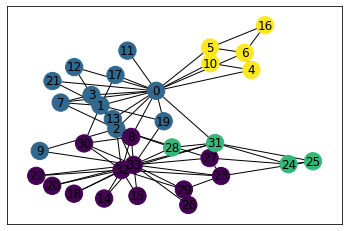

In [132]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
nx.draw_networkx(G,node_color=data.y,pos=nx.spring_layout(G, seed=42))

## Verificando empíricamente las propiedades de la matriz laplaciana
La idea de los siguientes ejercicios es verificar empíricamente las propiedades de la matriz laplaciana que se demuestran en el ejercicio opcional de abajo.

11. Calcular la matriz laplaciana $\mathbf{L}$ del grafo del karate club. Se sugiere utilizar alguna función del subpaquete [`torch_geometric.utils`](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html).
12. Vertificar que $\mathbf{L}$ tiene valor propio 0, y que el vector de unos $[1,1,\dots,1]^\top$ es vector propio con valor propio 0. El subpaquete [`torch.linalg`](https://pytorch.org/docs/stable/linalg.html) puede ser de utilidad.
13. Verificar que $\mathbf{L}$ es semidefinida positiva.
14. Armar una matriz $\tilde{\mathbf{B}}$ como la de la parte 2. del ejercicio opcional y verificar que $\mathbf{L}=\tilde{\mathbf{B}}\tilde{\mathbf{B}}^\top$. Se sugiere utilizar la función [`networkx.incidence_matrix`](https://networkx.org/documentation/stable/reference/generated/networkx.linalg.graphmatrix.incidence_matrix.html).

#### 11. Laplaciana

In [167]:
from torch_geometric.utils import get_laplacian
import torch

L = get_laplacian(data.edge_index, data.edge_weight)
L = torch.sparse_coo_tensor(L[0], L[1], size=(data.num_nodes, data.num_nodes))
L = L.to_dense()
L

tensor([[16., -1., -1.,  ..., -1.,  0.,  0.],
        [-1.,  9., -1.,  ...,  0.,  0.,  0.],
        [-1., -1., 10.,  ...,  0., -1.,  0.],
        ...,
        [-1.,  0.,  0.,  ...,  6., -1., -1.],
        [ 0.,  0., -1.,  ..., -1., 12., -1.],
        [ 0.,  0.,  0.,  ..., -1., -1., 17.]])

#### 11. Vectores propios

In [176]:
from torch import linalg

# no tienen parte imaginaria
eighvals = linalg.eigvals(L).to(torch.float64)
print("Valor propio más chico:", torch.min(eighvals).item())

Valor propio más chico: 8.614134685558383e-07


In [177]:
torch.ones(data.num_nodes) @ L


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### 13. Semidef positiva

In [178]:
eighvals > 0

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

14. B?

In [210]:
incidence_matrix = nx.incidence_matrix(G, oriented=True)
incidence_matrix = incidence_matrix.tocoo()

L_1 = incidence_matrix @ incidence_matrix.T
L_1 = L_1.todense()
L_1

/var/folders/p6/bczkg05n3kjbf6fdy02s4zd40000gn/T/ipykernel_35754/4256927489.py:1: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  incidence_matrix = nx.incidence_matrix(G, oriented=True)


array([[16., -1., -1., ..., -1.,  0.,  0.],
       [-1.,  9., -1., ...,  0.,  0.,  0.],
       [-1., -1., 10., ...,  0., -1.,  0.],
       ...,
       [-1.,  0.,  0., ...,  6., -1., -1.],
       [ 0.,  0., -1., ..., -1., 12., -1.],
       [ 0.,  0.,  0., ..., -1., -1., 17.]])

In [215]:
torch.equal(L, torch.tensor(L_1,dtype=torch.float32))

True

# Ejercicio opcional: demostrar algunas propiedades de la matriz laplaciana

Sea $G(V,E)$ un grafo simple (no dirigido, sin pesos y sin auto-aristas), con cantidad de vértices $N_v = |V|$ y cantidad de aristas $N_e = |E|$, y matriz de adyacencia $\mathbf{A}$. Sea $\mathbf{D} = \text{diag}(d_{1},\dots, d_{N_v})$ la matriz de grados y $\mathbf{L}=\mathbf{D}- \mathbf{A}$ la matriz laplaciana de $G$.

1. Verificar que el vector de unos $[1,1,\dots,1]^\top$ es vector propio de $\mathbf{L}$ con valor propio 0.
2. Aunque $G$ es un grafo no dirigido, podemos asignarle a cada arista en $E$ una orientación "virtual" arbitraria: para cada arista elegimos arbitrariamente uno de sus vértices como nodo inicial y el otro como nodo final. Dada esa asignación, definimos la *matriz de incidencia signada* $\tilde{\mathbf{B}} \in \{-1,0,1\}^{N_v\times N_e}$ con entrada $i,e$ dada por:
$$\tilde{\mathbf{B}}_{ie} = \left\lbrace
\begin{array}{r l}
1,& \text{si el vértice } i \text{ es el nodo inicial de la arista } e\\
-1,& \text{si el vértice } i \text{ es el nodo final de la arista } e\\
0,& \text{en otro caso}
\end{array}
\right. .
$$
Demostrar que la matriz laplaciana puede descomponerse como $\mathbf{L}=\tilde{\mathbf{B}}\tilde{\mathbf{B}}^\top$.

3. Sea $\mathbf{x} = [x_1,\dots,x_{N_v}]^\top \in \mathbb{R}^{N_v}$ un vector cualquiera. Usando el resultado de la parte 2, mostrar que
$$\mathbf{x}^\top \mathbf{L}\mathbf{x} = \sum_{(i,j) \in E} (x_i-x_j)^2$$
Concluir que $\mathbf{L}$ es una matriz simétrica y semidefinida positiva.

4. Demostrar que si $G$ no es conexo entonces $\mathbf{L}$ es diagonal por bloques, donde cada bloque corresponde a la matriz laplaciana de cada una de las componentes conexas de $G$. Probar que en este caso el subespacio propio asociado al valor propio 0 tiene dimensión mayor o igual a 2.

# Reconocimientos

La primera parte de la sección '**Una introducción a PyTorch Geometric**' está basada en [este notebook](https://colab.research.google.com/drive/16tqEHKOLUgYvXKx1V3blfYGpQb1_09MG?usp=sharing#scrollTo=bbny-iTO7NQN) del curso **[CS224W: Machine Learning with Graphs](http://web.stanford.edu/class/cs224w)** de Stanford.